In [49]:
import torch
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

os.environ['TOKENIZERS_PARALLELISM'] = 'true'

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [50]:
import pandas as pd

df = pd.read_hdf('data/reddit_demo.h5', key='df')

In [51]:
from datasets import Dataset
ds = Dataset.from_dict({'text': df['text']})

In [52]:
def dataloader(ds):
  for item in ds:
    yield item['text']

# Tone analysis

Checking the tone of submissions

In [53]:
from transformers import pipeline
from tqdm import tqdm

tone_pipe = pipeline("sentiment-analysis", 
  model="fine-tuning-final/tone", 
  device=device,
  max_length=512, 
  truncation=True
)

tone_labels = ['neutral', 'negative', 'positive']
res_tone = []
for res in tqdm(tone_pipe(dataloader(ds), top_k=len(tone_labels), batch_size=64), total=ds.num_rows):
  res_sorted = sorted(res, key=lambda x: x['label'])
  res_tone.append([x['score'] for x in res_sorted])

df = df.join(pd.DataFrame(res_tone, columns=tone_labels))

100%|██████████| 994/994 [00:23<00:00, 42.47it/s]


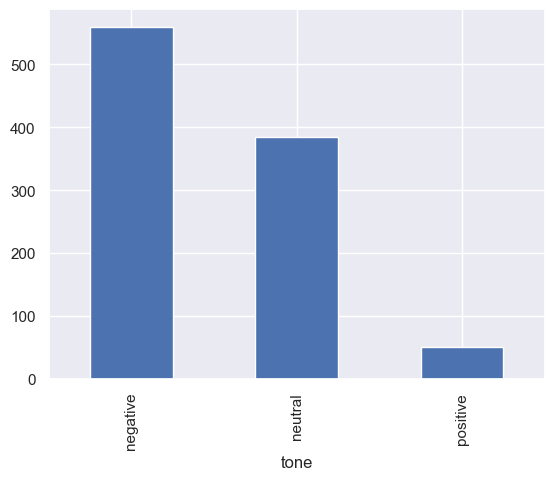

In [68]:
fig, ax = plt.subplots()
ax = df['tone'].value_counts().plot(kind='bar')

plt.show()

# Emotion Analysis

Checking the emotion of submissions

In [76]:
emotion_pipe('Cases of Covid are risiing!', top_k=len(emotion_labels), candidate_labels=emotion_labels)

{'sequence': 'Cases of Covid are risiing!',
 'labels': ['joy', 'love', 'anger', 'fear', 'surprise', 'sadness'],
 'scores': [0.35965749621391296,
  0.200651153922081,
  0.11086635291576385,
  0.11066596210002899,
  0.10916738957166672,
  0.10899163037538528]}

In [74]:
emotion_pipe = pipeline("zero-shot-classification", 
  model="fine-tuning-final/emotion", 
  device=device,
  max_length=512,
  truncation=True
)

emotion_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

res_tone = []
for res in tqdm(emotion_pipe(dataloader(ds), top_k=len(emotion_labels), batch_size=64, candidate_labels=emotion_labels), total=ds.num_rows):
  res_sorted = sorted(res, key=lambda x: x['label'])
  res_tone.append([x['score'] for x in res_sorted])

df = df.join(pd.DataFrame(res_tone, columns=emotion_labels))

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.
  0%|          | 0/994 [00:04<?, ?it/s]


TypeError: string indices must be integers, not 'str'

In [48]:
emotion_tokenizer, emotion_config, emotion_model = init_model("bhadresh-savani/distilbert-base-uncased-emotion")


In [49]:
from scipy.special import softmax
import numpy as np

emotion_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

def emotion_analysis(text: str):
  encoded_input = emotion_tokenizer(text, max_length=512, truncation=True, return_tensors='pt').to(device)
  output = emotion_model(**encoded_input)
  scores = output[0][0].detach().cpu().numpy()
  scores = softmax(scores)

  ranking = np.argsort(scores)
  ranking = ranking[::-1]

  output = {k: 0.0 for k in emotion_labels}

  for i in range(scores.shape[0]):
      k = emotion_config.id2label[ranking[i]]
      output[k] = scores[ranking[i]]
  
  return output

emotion_analysis("Covid cases are increasing fast!")

{'sadness': 0.011512363,
 'joy': 0.87378883,
 'love': 0.0020575349,
 'anger': 0.08232189,
 'fear': 0.026589878,
 'surprise': 0.0037294633}

In [85]:
for k in emotion_labels:
    df[k] = 0.0

In [86]:
for id in tqdm(df.index):
    text = preprocess_text(df.loc[id])
    output = emotion_analysis(text)
    for k in emotion_labels:
        df.at[id, k] = output[k]

In [87]:
df['emotion'] = df[emotion_labels].idxmax(axis=1)

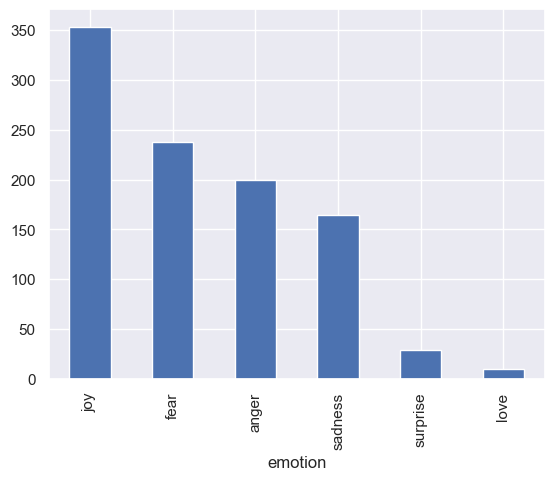

In [88]:
fig, ax = plt.subplots()
ax = df['emotion'].value_counts().plot(kind='bar')

plt.show()

In [89]:
df.to_hdf('data/reddit_process3.h5', key='df', mode='w')
df.to_csv('data/reddit_process3.csv', encoding='utf-8-sig')

/var/folders/lk/lhmn07j501l6rng06tjrl8cm0000gn/T/ipykernel_73820/4011226189.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['all_awardings', 'author', 'id', 'likes', 'media', 'media_embed',
       'permalink', 'title', 'selftext', 'view_count', 'tone', 'emotion'],
      dtype='object')]

  df.to_hdf('data/reddit_process3.h5', key='df', mode='w')


# Zero-shot classification

Classification of submissions based on certain categories

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig

def init_model(model_path: str):
    tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)
    config = AutoConfig.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)

    return (tokenizer, config, model)

In [81]:
theme_labels = ['clinical update', 'community', 'question', 'education', 'advocating', 'dissuading', 'other']
id2label = {i: k for i, k in enumerate(theme_labels)}
label2id = {k: i for i, k in enumerate(theme_labels)}

theme_model = AutoModelForSequenceClassification.from_pretrained("fine-tuning-final/theme",
  num_labels=len(theme_labels),
  id2label=id2label,
  label2id=label2id,
  ignore_mismatched_sizes=True
)

theme_tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-mnli", use_fast=True)

theme_pipe = pipeline("zero-shot-classification", 
  model=theme_model,
  tokenizer=theme_tokenizer,
  device=device,
  max_length=512,
  truncation=True
)

res_theme = []
for res in tqdm(theme_pipe(dataloader(ds), top_k=len(theme_labels), batch_size=64, candidate_labels=theme_labels), total=ds.num_rows):
  res_sorted = sorted(res, key=lambda x: x['label'])
  res_theme.append([x['score'] for x in res_sorted])

df = df.join(pd.DataFrame(res_theme, columns=theme_labels))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at fine-tuning-final/theme and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Exception: Impossible to guess which tokenizer to use. Please provide a PreTrainedTokenizer class or a path/identifier to a pretrained tokenizer.

In [52]:
theme_labels = ['clinical update', 'community', 'question', 'education', 'advocating', 'dissuading', 'other']

def theme_analysis(text: str, multi_label=False):
  res = zs_classifier(text, theme_labels, multi_label=multi_label)

  output = {k: 0.0 for k in theme_labels}

  for k, score in zip(res['labels'], res['scores']):
      output[k] = score
  
  return output

theme_analysis("Covid cases are increasing fast!")

{'clinical update': 0.35969823598861694,
 'community': 0.13439318537712097,
 'question': 0.19896970689296722,
 'education': 0.005827188026160002,
 'advocating': 0.11842522770166397,
 'dissuading': 0.1468779295682907,
 'other': 0.035808514803647995}

In [7]:
for k in theme_labels:
    df[k] = 0.0

In [8]:
for id in tqdm(df.index):
    text = preprocess_text(df.loc[id])
    output = theme_analysis(text)
    for k in theme_labels:
        df.at[id, k] = output[k]

100%|██████████| 994/994 [38:51<00:00,  2.35s/it]  


In [9]:
df['theme'] = df[theme_labels].idxmax(axis=1)

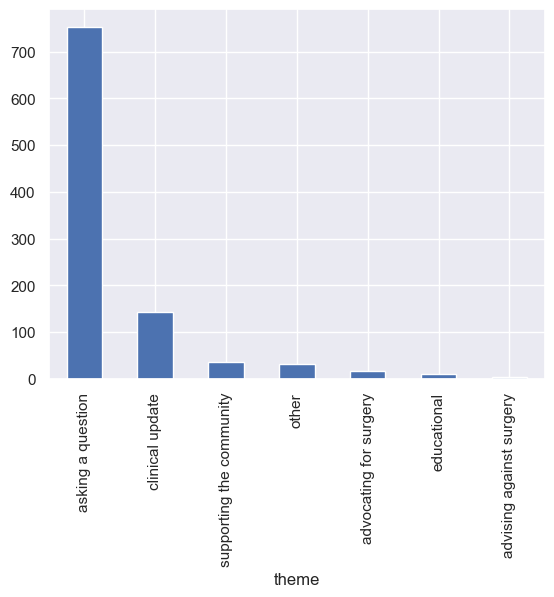

In [12]:
fig, ax = plt.subplots()
ax = df['theme'].value_counts().plot(kind='bar')

plt.show()

In [13]:
df.to_hdf('data/reddit_process4_2.h5', key='df', mode='w')
df.to_csv('data/reddit_process4_2.csv', encoding='utf-8-sig')

/var/folders/lk/lhmn07j501l6rng06tjrl8cm0000gn/T/ipykernel_87719/2136159091.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['all_awardings', 'author', 'id', 'likes', 'media', 'media_embed',
       'permalink', 'title', 'selftext', 'view_count', 'tone', 'emotion',
       'theme'],
      dtype='object')]

  df.to_hdf('data/reddit_process4_2.h5', key='df', mode='w')


# Natural Language Inference (NLI)

In NLI the model determines the relationship between two given texts. Concretely, the model takes a premise and a hypothesis and returns a class that can either be:

- **entailment**, which means the hypothesis is true.
- **contraction**, which means the hypothesis is false.
- **neutral**, which means there's no relation between the hypothesis and the premise.

### Multi-Genre NLI (MNLI)

```
Example 1:
    Premise: A man inspects the uniform of a figure in some East Asian country.
    Hypothesis: The man is sleeping.
    Label: Contradiction

Example 2:
    Premise: Soccer game with multiple males playing.
    Hypothesis: Some men are playing a sport.
    Label: Entailment
```

In [130]:
df.loc[df['selftext'] == '', ['title', 'media', 'media_embed']]

,title,media,media_embed
3,1 week post-op t5-l4 fusion! Looking for some ...,None,{}
7,I posted the other day about new shooting leg ...,None,{}
14,Anybody else get an infection and how did yall...,None,{}
23,6 weeks post ALIF 360 and on Thursday evening ...,None,{}
28,10 weeks out from L5 S1. Lifted around 8 pound...,None,{}
...,...,...,...
968,1 year post op and still struggling to lose th...,None,{}
969,Anyone have an acdf c5 - 7 to treat cervical m...,None,{}
976,Having my 3rd surgery Wednesday. Wish me luck…,None,{}
982,Three week follow up,None,{}


# Fine-tuning the models

Pulling manual data classification and placing it into train-validate datasets

In [206]:
import pandas as pd

df_chi = pd.read_csv('data/chi.csv')

In [207]:
tone_labels = ['negative', 'neutral', 'positive']
emotion_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
theme_labels = ['clinical update', 'community', 'question', 'education', 'advocating', 'dissuading', 'other']

In [208]:
df_chi.loc[:, tone_labels + emotion_labels + theme_labels].head()

,negative,neutral,positive,sadness,joy,love,anger,fear,surprise,clinical update,community,question,education,advocating,dissuading,other
0,negative,neutral,positive,sadness,joy,love,anger,fear,surprise,clinical update,community,question,education,advocating,dissuading,other
1,negative,neutral,positive,sadness,joy,love,anger,fear,surprise,clinical update,community,question,education,advocating,dissuading,other
2,negative,neutral,positive,sadness,joy,love,anger,fear,surprise,clinical update,community,question,education,advocating,dissuading,other
3,negative,neutral,positive,sadness,joy,love,anger,fear,surprise,clinical update,community,question,education,advocating,dissuading,other
4,negative,neutral,positive,sadness,joy,love,anger,fear,surprise,clinical update,community,question,education,advocating,dissuading,other


In [209]:
df_manual = df_chi.loc[~df_chi.loc[:, 'negative'].str.startswith('0.')]
df_manual.shape

(26, 35)

In [210]:
df_manual.loc[:,'selftext'] = df_manual.loc[:,'selftext'].fillna('')

In [211]:
# df_manual['text'] = df_manual.apply(lambda x: '\n'.join([str(x['title']), str(x['selftext'])]), axis=1)

In [212]:
from sklearn.model_selection import train_test_split

def train_test_val_split(df, train_size, val_size, test_size, random_state=42):
    """
    Splits a pandas dataframe into training, validation, and test sets.

    Args:
    - df: pandas dataframe to split.
    - train_size: float between 0 and 1 indicating the proportion of the dataframe to include in the training set.
    - val_size: float between 0 and 1 indicating the proportion of the dataframe to include in the validation set.
    - test_size: float between 0 and 1 indicating the proportion of the dataframe to include in the test set.
    - random_state: int or None, optional (default=42). The seed used by the random number generator.

    Returns:
    - train_df: pandas dataframe containing the training set.
    - val_df: pandas dataframe containing the validation set.
    - test_df: pandas dataframe containing the test set.

    Raises:
    - AssertionError: if the sum of train_size, val_size, and test_size is not equal to 1.
    """

    assert train_size + val_size + test_size == 1, "Train, validation, and test sizes must add up to 1."
    
    # Split the dataframe into training and test sets
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # Calculate the size of the validation set relative to the original dataframe
    val_ratio = val_size / (1 - test_size)
    
    # Split the training set into training and validation sets
    train_df, val_df = train_test_split(train_df, test_size=val_ratio, random_state=random_state)
    
    return train_df, val_df, test_df

In [213]:
cols = ['id', 'created_utc', 'author', 'title', 'selftext', 'tone', 'emotion', 'theme']
train_df, val_df, test_df = train_test_val_split(df_manual.loc[:, cols], 0.8, 0.1, 0.1)

In [214]:

manual_path_train = "data/chi_train.jsonl"
manual_path_validate = "data/chi_validate.jsonl"
manual_path_test = "data/chi_test.jsonl"
train_df.to_json(manual_path_train, orient="records", lines=True)
val_df.to_json(manual_path_validate, orient="records", lines=True)
test_df.to_json(manual_path_test, orient="records", lines=True)

In [215]:
from datasets import load_dataset

data_files = {
    'train': manual_path_train,
    'validate': manual_path_validate,
    'test': manual_path_test
}
manual_ds = load_dataset("json", data_files=data_files)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validate split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /Users/stefan/.cache/huggingface/datasets/json/default-3a27a5eb85090926/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [216]:
manual_ds

DatasetDict({
    train: Dataset({
        features: ['id', 'created_utc', 'author', 'title', 'selftext', 'tone', 'emotion', 'theme'],
        num_rows: 20
    })
    validate: Dataset({
        features: ['id', 'created_utc', 'author', 'title', 'selftext', 'tone', 'emotion', 'theme'],
        num_rows: 3
    })
    test: Dataset({
        features: ['id', 'created_utc', 'author', 'title', 'selftext', 'tone', 'emotion', 'theme'],
        num_rows: 3
    })
})

In [217]:
def concat_text(row):
    return {
        'text': row['title'] + '\n' + row['selftext']
    }

manual_ds = manual_ds.map(concat_text)

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [220]:
cols = manual_ds.column_names['train']
col_keep = {'text', 'tone'}
manual_ds = manual_ds.remove_columns(col_keep.symmetric_difference(cols))

In [221]:
manual_ds = manual_ds.class_encode_column('tone')
manual_ds['train'].features

ValueError: Class encoding is only supported for Value column, and column tone is ClassLabel.

In [222]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

def init_model(model_path: str):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    config = AutoConfig.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)

    return (tokenizer, config, model)

In [223]:
tone_tokenizer, tone_config, tone_model = init_model("cardiffnlp/twitter-roberta-base-sentiment-latest")

In [224]:
def tokenize_func(row):
  return tone_tokenizer(row['text'], max_length=512, padding='max_length', truncation=True, return_tensors='pt')

manual_ds = manual_ds.map(tokenize_func, batched=True)

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [238]:
manual_ds = manual_ds.rename_column('tone', 'label')

In [247]:
manual_ds

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 20
    })
    validate: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 3
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 3
    })
})

In [239]:
import numpy as np
import evaluate

metric = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [252]:
from transformers import Trainer, TrainingArguments, logging

logging.set_verbosity_error()

logging_steps = len(manual_ds['train'])
model_name = "tone-finetuned"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    log_level="error",
    use_mps_device=True
)

trainer = Trainer(
    model=tone_model,
    args=training_args,
    train_dataset=manual_ds['train'],
    eval_dataset=manual_ds['validate'],
    compute_metrics=compute_metrics,
    tokenizer=tone_tokenizer
)

print("Trainer device:",trainer.args.device)

Trainer device: mps


In [253]:
def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")

In [254]:
result = trainer.train()
print_summary(result)

/Users/stefan/.local/share/virtualenvs/fusion_analysis-xH46poxW/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 2.143649101257324, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.0725, 'eval_samples_per_second': 41.357, 'eval_steps_per_second': 13.786, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.6097502708435059, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.0731, 'eval_samples_per_second': 41.033, 'eval_steps_per_second': 13.678, 'epoch': 2.0}
{'train_runtime': 3.9556, 'train_samples_per_second': 10.112, 'train_steps_per_second': 1.517, 'train_loss': 0.015602140376965204, 'epoch': 2.0}
Time: 3.96
Samples/second: 10.11


In [257]:
trainer.save_model('tone-finetined-final')